In [1]:
# https://wikidocs.net/86900 참고

import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import re
import io

import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = "/content/drive/MyDrive/2022_R&E_Program/번역_예제코드/관동별곡.txt"

In [4]:
# 유니코드 파일을 아스키 코드 파일로 변환합니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다. 
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  w = re.sub(r"['ㅣ가-힣?.!,]+", r" ", w)

  w = w.strip() # 문장 양 끝의 공백 제거

  # # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # # 문장에 start와 end 토큰을 추가합니다.
  # w = '<start> ' + w + ' <end>'
  return w

def decoder_preprocess(seq):
  decoder_in = []
  decoder_out = []
  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  for w in seq:
    decoder_in.append('<start> ' + w)
    decoder_out.append(w + ' <end>')
  return tuple(decoder_in), tuple(decoder_out)

In [5]:
def create_dataset(file_path, num_examples):
  lines = io.open(file_path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('|')]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [6]:
ko, ko2 = create_dataset(file_path, None)
ko2_1, ko2_2 = decoder_preprocess(ko2)
print(ko[-1])
print(ko2_1[-1])
print(ko2_2[-1])

명월이 천산만낙의 아니비쵠ᄃᆡ 업다
<start> 밝은 달이 온 세상에 아니 비친 곳 없다
밝은 달이 온 세상에 아니 비친 곳 없다 <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

def tokenize_dec(lang):
  lang1, lang2 = decoder_preprocess(lang)

  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang1)
  lang_tokenizer.fit_on_texts(lang2)

  tensor_in = lang_tokenizer.texts_to_sequences(lang1)
  tensor_in = tf.keras.preprocessing.sequence.pad_sequences(tensor_in, padding='post')

  tensor_out = lang_tokenizer.texts_to_sequences(lang2)
  tensor_out = tf.keras.preprocessing.sequence.pad_sequences(tensor_out, padding='post')

  return tensor_in, tensor_out, lang_tokenizer

In [ ]:
def load_dataset(file_path, num_examples=None):
  # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
  inp_lang, targ_lang = create_dataset(file_path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_in_tensor, target_out_tensor, targ_lang_tokenizer = tokenize_dec(targ_lang)

  return input_tensor, target_in_tensor, target_out_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 30000
input_tensor, target_in_tensor, target_out_tensor, inp_lang, targ_lang = load_dataset(file_path, num_examples)

# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_in_tensor.shape[1], input_tensor.shape[1]

In [ ]:
input_tensor[0]

array([22, 23, 24, 25,  0,  0,  0,  0], dtype=int32)

In [ ]:
target_in_tensor[0:5]

array([[ 1, 70, 71, 72, 73, 74,  0,  0,  0,  0],
       [ 1, 75, 76, 77, 78, 79,  0,  0,  0,  0],
       [ 1,  9, 80, 81, 82,  0,  0,  0,  0,  0],
       [ 1, 83, 84, 85, 86, 24,  0,  0,  0,  0],
       [ 1, 87, 88, 89, 25, 90,  0,  0,  0,  0]], dtype=int32)

In [ ]:
target_out_tensor[0:5]

array([[70, 71, 72, 73, 74,  2,  0,  0,  0,  0],
       [75, 76, 77, 78, 79,  2,  0,  0,  0,  0],
       [ 9, 80, 81, 82,  2,  0,  0,  0,  0,  0],
       [83, 84, 85, 86, 24,  2,  0,  0,  0,  0],
       [87, 88, 89, 25, 90,  2,  0,  0,  0,  0]], dtype=int32)

In [ ]:
n_of_val = int(len(input_tensor)*0.2)
print('학습 데이터의 개수 :',len(input_tensor)-n_of_val)
print('검증 데이터의 개수 :',n_of_val)

# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val = input_tensor[:-n_of_val], input_tensor[-n_of_val:]
target_in_tensor_train, target_in_tensor_val = target_in_tensor[:-n_of_val], target_in_tensor[-n_of_val:]
target_out_tensor_train, target_out_tensor_val = target_out_tensor[:-n_of_val], target_out_tensor[-n_of_val:]

학습 데이터의 개수 : 116
검증 데이터의 개수 : 29


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target input Language; index to word mapping")
convert(targ_lang, target_in_tensor_train[0])
print ()
print ("Target output Language; index to word mapping")
convert(targ_lang, target_out_tensor_train[0])

Input Language; index to word mapping
22 ----> 강호에
23 ----> 병이깁퍼
24 ----> 듁님의
25 ----> 누엇더니

Target input Language; index to word mapping
1 ----> <start>
70 ----> 강호에
71 ----> 병이
72 ----> 깊어
73 ----> 대숲에
74 ----> 누었더니

Target output Language; index to word mapping
70 ----> 강호에
71 ----> 병이
72 ----> 깊어
73 ----> 대숲에
74 ----> 누었더니
2 ----> <end>


In [ ]:
print(input_tensor_train.shape, input_tensor_val.shape)
print(target_in_tensor_train.shape, target_in_tensor_val.shape)
print(target_out_tensor_train.shape, target_out_tensor_val.shape)

(116, 8) (29, 8)
(116, 10) (29, 10)
(116, 10) (29, 10)


In [ ]:
in_vocab_size = len(inp_lang.word_index) + 1
tar_vocab_size = len(targ_lang.word_index) + 1
print("고전문학 단어 집합의 크기 : {:d}, 현대어 단어 집합의 크기 : {:d}".format(in_vocab_size, tar_vocab_size))

고전문학 단어 집합의 크기 : 577, 현대어 단어 집합의 크기 : 656


In [ ]:
embedding_dim = 64
hidden_units = 64

In [ ]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(in_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
his = model.fit(x=[input_tensor_train, target_in_tensor_train], y=target_out_tensor_train, \
          validation_data=([input_tensor_val, target_in_tensor_val], target_out_tensor_val),
          batch_size=16, epochs=100)

Epoch 1/100
8/8 [==============================] - 16s 529ms/step - loss: 6.4766 - acc: 0.2474 - val_loss: 6.4640 - val_acc: 0.3000
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 6.4190 - acc: 0.3897 - val_loss: 6.3873 - val_acc: 0.3000
Epoch 3/100
8/8 [==============================] - 0s 32ms/step - loss: 6.1441 - acc: 0.3897 - val_loss: 5.8755 - val_acc: 0.3000
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 5.1508 - acc: 0.3897 - val_loss: 5.2648 - val_acc: 0.3000
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 4.4172 - acc: 0.3897 - val_loss: 5.1265 - val_acc: 0.3000
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 4.0796 - acc: 0.3897 - val_loss: 5.2171 - val_acc: 0.3000
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 3.9484 - acc: 0.3897 - val_loss: 5.2055 - val_acc: 0.3000
Epoch 8/100
8/8 [==============================] - 0s 29ms/step - loss: 3.8123 - acc: 0.

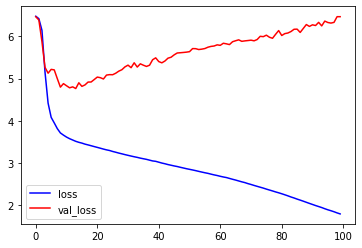

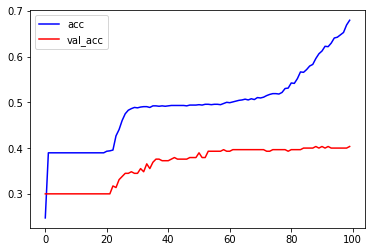

In [ ]:
plt.plot(his.history['loss'], '-b', label='loss')
plt.plot(his.history['val_loss'], '-r', label='val_loss')
plt.legend()
plt.show()

plt.plot(his.history['acc'], '-b', label='acc')
plt.plot(his.history['val_acc'], '-r', label='val_acc')
plt.legend()
plt.show()

In [ ]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [ ]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = targ_lang.word_index['<start>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = targ_lang.index_word[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<end>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + inp_lang.index_word[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      if (encoded_word != targ_lang.word_index['<start>']):
         if (encoded_word != targ_lang.word_index['<end>']):
           sentence = sentence + targ_lang.index_word[encoded_word] + ' '
  return sentence

In [ ]:
for seq_index in [11, 22, 33, 44, 55]:
  input_seq = input_tensor_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(input_tensor_train[seq_index]))
  print("정답문장 :",seq_to_tar(target_in_tensor_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : 궁왕 대궐터희 오쟉이 지지괴니 
정답문장 : 궁왕 대궐터에 까막까치가 지저귀니 
번역문장 : 예서 사흘 머문 후에 어디 가 
--------------------------------------------------
입력문장 : 금강ᄃᆡ ᄆᆡᆫ우층의 션학이 삿기치니 
정답문장 : 금강대 맨 위층에 선학이 새끼치니 
번역문장 : 금강대 맺혀있고 동해로 어디 어디 
--------------------------------------------------
입력문장 : 놉흘시고 망고ᄃᆡ 외로올샤 혈망봉이 
정답문장 : 높을시고 망고대 외롭구나 혈망봉아 
번역문장 : 높을시고 망고대 외롭구나 
--------------------------------------------------
입력문장 : 이제와 보게되니 유정도 유정정ᄒᆞᆯ샤 
정답문장 : 이제와 보게되니 유정도 유정하구나 
번역문장 : 아아 다시올라 많다 
--------------------------------------------------
입력문장 : 풍운을 언제어더 삼일우ᄅᆞᆯ 디련ᄂᆞᆫ다 
정답문장 : 풍운을 언제 얻어 삼일우를 내리려나 
번역문장 : 오월 장천에 무슨 내어 내어 
--------------------------------------------------


In [ ]:
for seq_index in [1, 7, 12, 15, 18]:
  input_seq = input_tensor_val[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(input_tensor_val[seq_index]))
  print("정답문장 :",seq_to_tar(target_in_tensor_val[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : 부상 지쳑의 명월을 기ᄃᆞ리니 
정답문장 : 부상 가까이서 밝은 달을 기다리니 
번역문장 : 낙산 넓은 다 어찌하여 말인가 
--------------------------------------------------
입력문장 : 뉴하쥬 ᄀᆞ득부어 ᄃᆞᆯᄃᆞ려 무론말이 
정답문장 : 유하주 가득 부어 달더러 묻는 말이 
번역문장 : 천지 저절로 내어 
--------------------------------------------------
입력문장 : ᄭᅮᆷ애 ᄒᆞᆫ사ᄅᆞᆷ이 날ᄃᆞ려 닐온말이 
정답문장 : 꿈에 한 사람이 날더러 이른 말이 
번역문장 : 천지 저절로 내어 
--------------------------------------------------
입력문장 : 인간의 내려와셔 우리ᄅᆞᆯ ᄯᆞᆯ오ᄂᆞᆫ다 
정답문장 : 인간 세계에 내려와서 우리를 따르는가 
번역문장 : 낙산 넓은 언덕으로 의상대에 
--------------------------------------------------
입력문장 : 저먹고 날머겨놀 서너잔 거후로니 
정답문장 : 저 먹고 날 먹이거늘 서너 잔 기울이니 
번역문장 : 천지 저절로 내어 
--------------------------------------------------
